In [ ]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

In [1]:
import sklearn
import cv2
import pandas as pd
import numpy as np
import os

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
!rm -r /content/data/train_set/not_penguin

In [ ]:
#!pip install patool
import patoolib
#patoolib.extract_archive("/content/drive/My Drive/Colab Notebooks/data/train_set.rar", outdir="/content/data")

patool: Extracting /content/drive/My Drive/Colab Notebooks/data/train_set.rar ...
patool: running /usr/bin/unrar x -- "/content/drive/My Drive/Colab Notebooks/data/train_set.rar"
patool:     with cwd='/content/data'
patool: ... /content/drive/My Drive/Colab Notebooks/data/train_set.rar extracted to `/content/data'.


'/content/data'

In [129]:
import shutil
shutil.make_archive('model', 'zip', '/content/model')

'/content/model.zip'

In [ ]:
#!cp /content/all_aug_photos.zip "/content/drive/My Drive/Colab Notebooks/data"

### Дані.
Даних не надто багато, і щоб якось розширити набори трошки аугумнетації:

In [ ]:
import random
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util
from PIL import Image

def random_rotation(imagePath: str):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    image_array = plt.imread(imagePath)
    random_degree = random.uniform(-25, 25)
    img = sk.transform.rotate(image_array, random_degree)
    plt.imsave(imagePath[:-4]+ '_rotation.jpg', img)

def random_noise(imagePath: str):
    # add random noise to the image
    image_array = plt.imread(imagePath)
    img = sk.util.random_noise(image_array)
    plt.imsave(imagePath[:-4]+ '_noise.jpg', img)

def horizontal_flip(imagePath: str):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    image = plt.imread(imagePath)
    plt.imsave(imagePath[:-4]+ '_hor_flip.jpg', image[:, ::-1])

def verical_flip(imagePath: str):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    image = plt.imread(imagePath)
    plt.imsave(imagePath[:-4]+ '_ver_flip.jpg', image[::-1, :])

In [ ]:
def aug_img(folder):
  data_set = [os.path.join(folder,file) for file in os.listdir(folder) if os.path.isfile(os.path.join(folder,file))]

  for img_path in random.sample(data_set, len(data_set)//2):
    random_rotation(img_path)
  
  for img_path in random.sample(data_set, len(data_set)//2):
    random_noise(img_path)

  for img_path in random.sample(data_set, len(data_set)//2):
    horizontal_flip(img_path)

  for img_path in random.sample(data_set, len(data_set)//2):
    verical_flip(img_path)    

In [ ]:
!find data/train_set/not_penguin/ -maxdepth 1 -type f -name "*noise2.jpg" -delete

In [ ]:
aug_img('/content/data/train_set/penguin')
aug_img('/content/data/train_set/not_penguin')

aug_img('/content/data/val_set/penguin')
aug_img('/content/data/val_set/not_penguin')

Приклад фото з різних класів:

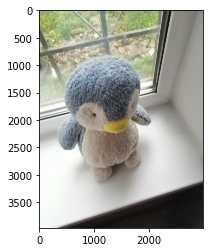

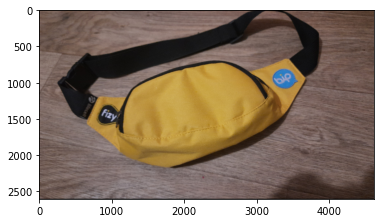

In [ ]:
with sns.axes_style({'axes.grid': False}):
    plt.figure(0)
    plt.imshow(plt.imread('/content/data/train_set/penguin/IMG_20200927_101206.jpg')), plt.show()

    plt.figure(1)
    plt.imshow(plt.imread('/content/data/train_set/not_penguin/20200925_232742.jpg')), plt.show()

In [9]:
def get_set_size(folder):
  data_set = [os.path.join(folder,file) for file in os.listdir(folder) if os.path.isfile(os.path.join(folder,file))]
  return len(data_set)

# Фото

### Нейроночка.
Нічого надзвичайного чи дуже витонченого. Та навіть цієї простої архітектури та маленького набору даних вистачить для того, щоб продемонстувати роботу.

Генератори для подальшого використання в тренуванні нейроночки.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
        '/content/data/train_set',  # This is the source directory for training images
        classes = ['not_penguin', 'penguin'],
        target_size=(64, 64),  # All images will be resized to 200x200
        batch_size=10,
        # Use binary labels
        class_mode='binary')

# Flow validation images in batches of 19 using valid_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        '/content/data/val_set',  # This is the source directory for training images
        classes = ['not_penguin', 'penguin'],
        target_size=(64, 64),  # All images will be resized to 200x200
        batch_size=5,
        # Use binary labels
        class_mode='binary',
        shuffle=False)

Found 638 images belonging to 2 classes.
Found 74 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv1D, Conv2D, MaxPooling2D,MaxPooling1D, Activation
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64,64,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)            

In [ ]:
model.compile(optimizer = Adam(),
              loss = sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator,
      steps_per_epoch=60,  
      epochs = 5,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)

Epoch 1/5
60/60 [==============================] - 140s 2s/step - loss: 0.0867 - accuracy: 0.9682 - val_loss: 0.1119 - val_accuracy: 0.9750
Epoch 2/5
60/60 [==============================] - 131s 2s/step - loss: 0.0593 - accuracy: 0.9816 - val_loss: 0.1435 - val_accuracy: 0.9500
Epoch 3/5
60/60 [==============================] - 130s 2s/step - loss: 0.0409 - accuracy: 0.9883 - val_loss: 0.0410 - val_accuracy: 0.9750
Epoch 4/5
60/60 [==============================] - 130s 2s/step - loss: 0.0347 - accuracy: 0.9866 - val_loss: 0.0323 - val_accuracy: 0.9750
Epoch 5/5
60/60 [==============================] - 135s 2s/step - loss: 0.0236 - accuracy: 0.9933 - val_loss: 0.1394 - val_accuracy: 0.9750


Як кажуть, Not Great, Not Terrible.

Для наших цілей, на мою думку, цього вистачає. 100 фото в тренувальному + 10 в тестувальному (валідаційному) наборах. 

In [ ]:
model.evaluate(validation_generator)

15/15 [==============================] - 17s 1s/step - loss: 0.0782 - accuracy: 0.9865


[0.07823821902275085, 0.9864864945411682]

In [ ]:
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size
validation_generator.reset()
preds = model.predict(validation_generator,
                      verbose=1)

15/15 [==============================] - 15s 1s/step


### Трошечки візуалізації результатів.




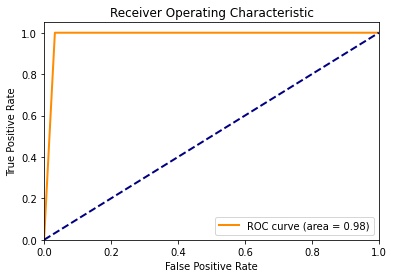

In [ ]:
fpr, tpr, _ = roc_curve(validation_generator.classes, [round(i[1]) for i in preds])

roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

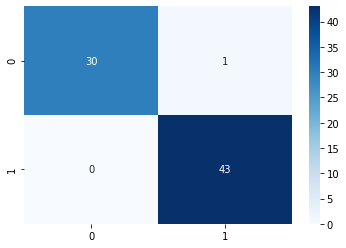

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cf_matrix = confusion_matrix(validation_generator.classes, [round(i[1]) for i in preds])
sns.heatmap(cf_matrix, annot=True, cmap='Blues')

In [ ]:
print(classification_report(validation_generator.classes, np.argmax(preds,axis=-1)))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        31
           1       0.98      1.00      0.99        43

    accuracy                           0.99        74
   macro avg       0.99      0.98      0.99        74
weighted avg       0.99      0.99      0.99        74



Як на мене то для такої простої архітектури результати чудові.

### І тут з'являється дескриптор.

In [10]:
import tensorflow as tf
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Reshape, Flatten, BatchNormalization, Conv1D, Conv2D, MaxPooling2D,MaxPooling1D, Activation
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam

In [11]:
descriptors={'orb': cv2.ORB_create().detectAndCompute,
             'sift': cv2.xfeatures2d.SIFT_create().detectAndCompute}

In [12]:
from tensorflow.keras.layers import Lambda
import imgaug as ia
import imgaug.augmenters as iaa

Ключові точки після обрахунку дескрипторів та приведення їх до одної довжини рядка.

In [7]:
def get_key_pts(algorithm,img):
  try:
    gray = cv2.cvtColor(np.array(img),cv2.COLOR_RGB2GRAY)
    gray*=255
    gray=gray.astype('uint8')
    _, descr = algorithm(gray,None)
    # in case the descr is empty
    try:
      return descr.flatten().astype('float32')
    except:
      return np.array([0.0, 0.0])
  except Exception as e:
    return np.array([0.0, 0.0])

def to_same_dims(array, dim):
  kp = np.zeros([len(array),dim])
  for i, j in enumerate(array):
    if len(j) >= dim:
      kp[i] = j[:dim]
    else:
      kp[i] = np.array(list(j) + list(np.zeros(dim - len(j))))
  return kp 

Генератор ключових точок.

In [7]:
def keypoint_generator(features, labels, batch_size, crop, algorithm):
  batch_features = []
  batch_labels = []
  while True:
    indexes = np.random.choice(features.shape[0], batch_size)
    #img_batch = [features[i] for i in indexes]
    #batch_labels = np.array([labels[i] for i in indexes])

    img_batch = [features[i] for i in indexes]
    #batch_features = [img/255.0 for img in img_batch]

    yield img_batch, batch_labels

### ORB

In [10]:
X = [os.path.join('/content/data/train_set/penguin',file) for file in os.listdir('/content/data/train_set/penguin') if os.path.isfile(os.path.join('/content/data/train_set/penguin',file))] + [os.path.join('/content/data/train_set/not_penguin',file) for file in os.listdir('/content/data/train_set/not_penguin') if os.path.isfile(os.path.join('/content/data/train_set/not_penguin',file))] 
y = [1] * get_set_size('/content/data/train_set/penguin') + [0] * get_set_size('/content/data/train_set/not_penguin')

In [11]:
data = []
for img in X:
  des = get_key_pts(descriptors['orb'], cv2.imread(img))
  des/=255.0
  data.append(des)

data_dims = to_same_dims(data, 1024)

In [116]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data_dims, y, test_size=0.2, random_state=42)

In [117]:
model_des = Sequential()
model_des.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(1024,1)))
model_des.add(MaxPooling1D(pool_size=2))
model_des.add(Dropout(0.25))
model_des.add(Conv1D(64, kernel_size=3, activation='relu'))
model_des.add(MaxPooling1D(pool_size=2))
model_des.add(Dropout(0.25))
model_des.add(Flatten())
model_des.add(Dense(100, activation='relu'))
model_des.add(Dense(2, activation='softmax'))

model_des.summary()

opt = Adam(learning_rate=1e-3, decay=1e-3/32)

model_des.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 1022, 32)          128       
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 511, 32)           0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 511, 32)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 509, 64)           6208      
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 254, 64)           0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 254, 64)           0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 16256)            

In [118]:
X_train = np.expand_dims(x_train, axis=2)
X_test = np.expand_dims(x_test, axis=2)

history = model_des.fit(X_train, np.array(y_train),
                      batch_size=30,
                      epochs=10,
                      #validation_data=(X_test, np.array(y_test)),
                      verbose=1)

Epoch 1/10
16/16 [==============================] - 1s 58ms/step - loss: 0.8015 - accuracy: 0.4945
Epoch 2/10
16/16 [==============================] - 1s 58ms/step - loss: 0.6942 - accuracy: 0.4923
Epoch 3/10
16/16 [==============================] - 1s 58ms/step - loss: 0.6936 - accuracy: 0.5361
Epoch 4/10
16/16 [==============================] - 1s 58ms/step - loss: 0.6932 - accuracy: 0.5252
Epoch 5/10
16/16 [==============================] - 1s 58ms/step - loss: 0.6932 - accuracy: 0.5011
Epoch 6/10
16/16 [==============================] - 1s 57ms/step - loss: 0.6932 - accuracy: 0.5274
Epoch 7/10
16/16 [==============================] - 1s 58ms/step - loss: 0.6932 - accuracy: 0.5077
Epoch 8/10
16/16 [==============================] - 1s 58ms/step - loss: 0.6932 - accuracy: 0.5230
Epoch 9/10
16/16 [==============================] - 1s 58ms/step - loss: 0.6932 - accuracy: 0.4945
Epoch 10/10
16/16 [==============================] - 1s 59ms/step - loss: 0.6932 - accuracy: 0.5164


In [119]:
model_des.evaluate(X_test, np.array(y_test), batch_size=16)

preds = model_des.predict(X_test, verbose=1)

8/8 [==============================] - 0s 9ms/step - loss: 0.6932 - accuracy: 0.6348


[0.6931533813476562, 0.634782612323761]

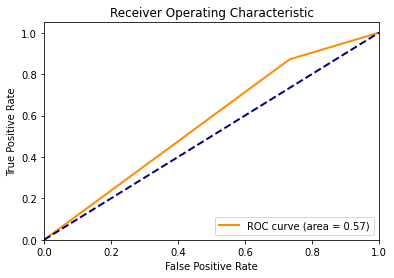

In [121]:
fpr, tpr, _ = roc_curve(y_test, [round(i[1]) for i in preds])

roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

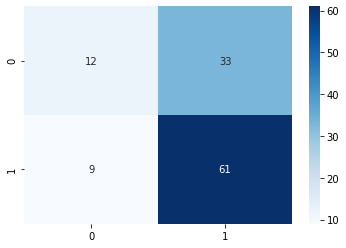

In [122]:
from sklearn.metrics import confusion_matrix, classification_report

cf_matrix = confusion_matrix(y_test, [round(i[1]) for i in preds])
sns.heatmap(cf_matrix, annot=True, cmap='Blues')

In [123]:
print(classification_report(y_test, np.argmax(preds,axis=-1)))

              precision    recall  f1-score   support

           0       0.57      0.27      0.36        45
           1       0.65      0.87      0.74        70

    accuracy                           0.63       115
   macro avg       0.61      0.57      0.55       115
weighted avg       0.62      0.63      0.60       115



### SIFT

In [131]:
X = [os.path.join('/content/data/train_set/penguin',file) for file in os.listdir('/content/data/train_set/penguin') if os.path.isfile(os.path.join('/content/data/train_set/penguin',file))] + [os.path.join('/content/data/train_set/not_penguin',file) for file in os.listdir('/content/data/train_set/not_penguin') if os.path.isfile(os.path.join('/content/data/train_set/not_penguin',file))] 
y = [1] * get_set_size('/content/data/train_set/penguin') + [0] * get_set_size('/content/data/train_set/not_penguin')

In [132]:
data_sift = []
for img in X:
  des = get_key_pts(descriptors['sift'], cv2.imread(img))
  des/=255.0
  data_sift.append(des)

data_dims_sift = to_same_dims(data_sift, 1024)

In [155]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data_dims_sift, y, test_size=0.2, random_state=42)

In [201]:
model_sift = Sequential()
model_sift.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(1024,1)))
model_sift.add(MaxPooling1D(pool_size=2))
model_sift.add(Dropout(0.25))
model_sift.add(Conv1D(64, kernel_size=3, activation='relu'))
model_sift.add(MaxPooling1D(pool_size=2))
model_sift.add(Dropout(0.25))
model_sift.add(Flatten())
model_sift.add(Dense(100, activation='relu'))
model_sift.add(Dense(2, activation='softmax'))

model_sift.summary()

opt = Adam(learning_rate=1e-3, decay=1e-3/32)

model_sift.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_48 (Conv1D)           (None, 1022, 32)          128       
_________________________________________________________________
max_pooling1d_48 (MaxPooling (None, 511, 32)           0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 511, 32)           0         
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 509, 64)           6208      
_________________________________________________________________
max_pooling1d_49 (MaxPooling (None, 254, 64)           0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 254, 64)           0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 16256)           

In [204]:
X_train = np.expand_dims(x_train, axis=2)
X_test = np.expand_dims(x_test, axis=2)

history = model_sift.fit(X_train, np.array(y_train),
                      batch_size=30,
                      epochs=10,
                      verbose=1)

Epoch 1/10
16/16 [==============================] - 1s 59ms/step - loss: 0.6931 - accuracy: 0.5186
Epoch 2/10
16/16 [==============================] - 1s 60ms/step - loss: 0.6931 - accuracy: 0.5295
Epoch 3/10
16/16 [==============================] - 1s 60ms/step - loss: 0.6931 - accuracy: 0.5383
Epoch 4/10
16/16 [==============================] - 1s 59ms/step - loss: 0.6931 - accuracy: 0.5339
Epoch 5/10
16/16 [==============================] - 1s 59ms/step - loss: 0.6931 - accuracy: 0.5274
Epoch 6/10
16/16 [==============================] - 1s 59ms/step - loss: 0.6931 - accuracy: 0.5339
Epoch 7/10
16/16 [==============================] - 1s 59ms/step - loss: 0.6931 - accuracy: 0.5339
Epoch 8/10
16/16 [==============================] - 1s 59ms/step - loss: 0.6931 - accuracy: 0.5317
Epoch 9/10
16/16 [==============================] - 1s 59ms/step - loss: 0.6931 - accuracy: 0.5295
Epoch 10/10
16/16 [==============================] - 1s 58ms/step - loss: 0.6931 - accuracy: 0.5339


In [205]:
model_sift.evaluate(X_test, np.array(y_test), batch_size=16)

preds = model_sift.predict(X_test, verbose=1)

4/4 [==============================] - 0s 11ms/step


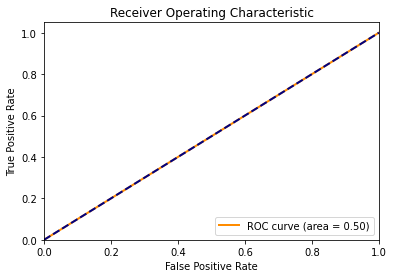

In [206]:
fpr, tpr, _ = roc_curve(y_test, [round(i[1]) for i in preds])

roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

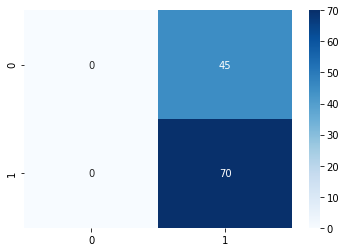

In [207]:
from sklearn.metrics import confusion_matrix, classification_report

cf_matrix = confusion_matrix(y_test, [round(i[1]) for i in preds])
sns.heatmap(cf_matrix, annot=True, cmap='Blues')

In [140]:
print(classification_report(y_test, np.argmax(preds,axis=-1)))

              precision    recall  f1-score   support

           0       0.42      0.33      0.37        45
           1       0.62      0.70      0.66        70

    accuracy                           0.56       115
   macro avg       0.52      0.52      0.51       115
weighted avg       0.54      0.56      0.55       115



На SIFT все спрацювало це гірше.
Як виявилось, у іншого члена моєї групи, що працював з SIFT, схожі результати.

### Висновки: 

Модель з дескрипторами навчається швидше (так як даних менше). Але однозначно порівнювати результати цієї мережі та CNN натренованих на фото не можна. 

Ця точність в обумовлена не в останню чергу через різницею в кількості представників класів у тестовому наборі. 

Я пробувала декілька змін в архітектурі, іншу кількість features, різні розміри датасатів. Відчутних змін не було.

33 випадки помилки 2 роду, 9 - помилки 1 роду. 


Загальний висновок по методу: без дескрипторів все набагато краще працює.

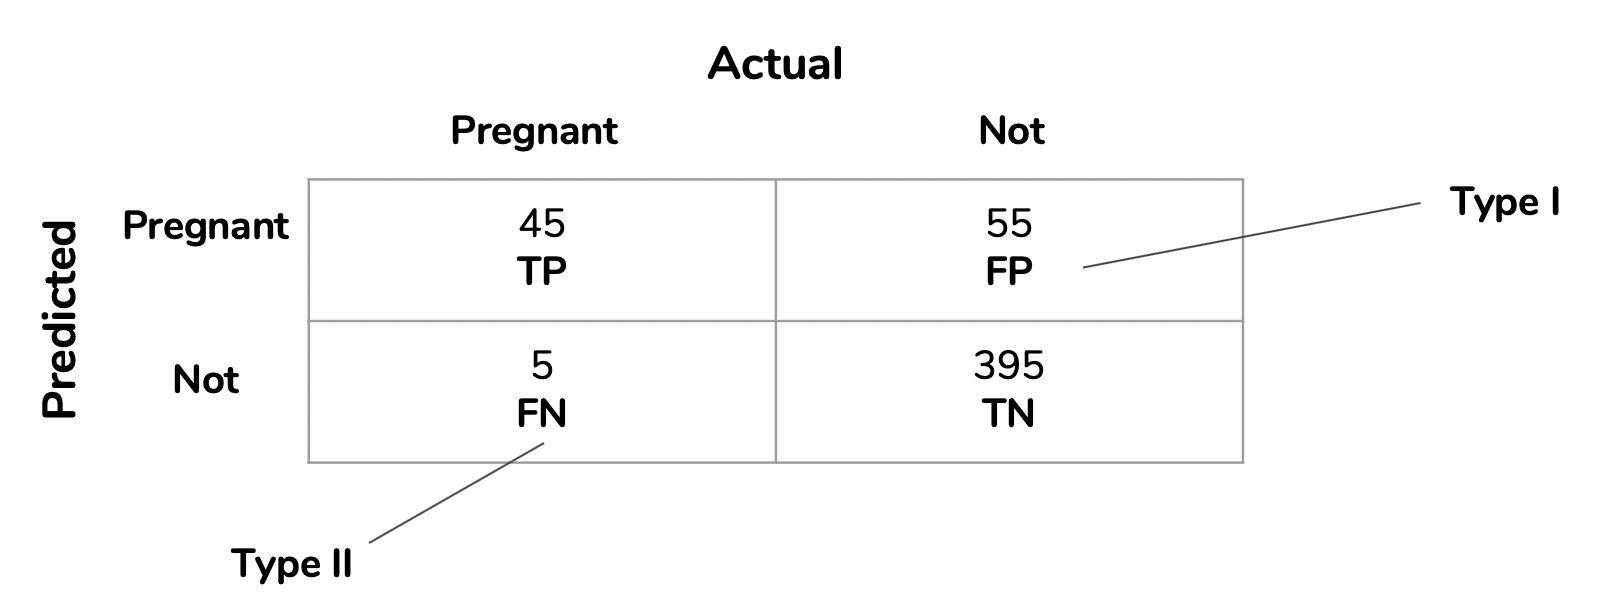

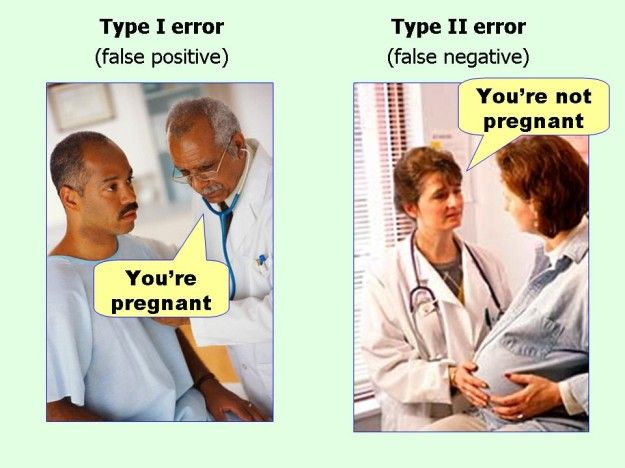

In [ ]:
model_des.save('/content/model')

# Відео

In [8]:
from tensorflow.keras.models import load_model

In [9]:
model_video = load_model('/content/model')

In [33]:
import time
import cv2

cap = cv2.VideoCapture('/content/penguin.mp4')
if cap.isOpened() == False:
    print('Oops... The video was not opened. Check the path')

width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

output = cv2.VideoWriter('test_video.avi', cv2.VideoWriter_fourcc(*'DIVX'),20,(width, height), isColor=True)

while cap.isOpened():
    ret, frame = cap.read()

    data = get_key_pts(descriptors['orb'], frame)
    data/=255.0
    data_dims = to_same_dims([list(data)], 1024)
    X = np.expand_dims(data_dims, axis=2)
    preds = model_video.predict(X, verbose=0)
    text_to_output = 'Class ' + str(round(preds[0][1]))

    font = cv2.FONT_HERSHEY_SIMPLEX 
   
    if ret:
        cv2.putText(frame, text_to_output, org = (50,50),  
                   fontScale = 1, color = (255, 0, 0), thickness = 2, fontFace = cv2.LINE_AA) 
        output.write(frame)       
    else:
        break
cap.release()
output.release()